In [ ]:
import pandas as pd

df = pd.read_csv("../data/crypto-markets.csv")

# Display the first few rows of the DataFrame
print(df.head())

      slug symbol     name        date  ranknow    open    high     low  \
0  bitcoin    BTC  Bitcoin  2013-04-28        1  135.30  135.98  132.10   
1  bitcoin    BTC  Bitcoin  2013-04-29        1  134.44  147.49  134.00   
2  bitcoin    BTC  Bitcoin  2013-04-30        1  144.00  146.93  134.05   
3  bitcoin    BTC  Bitcoin  2013-05-01        1  139.00  139.89  107.72   
4  bitcoin    BTC  Bitcoin  2013-05-02        1  116.38  125.60   92.28   

    close  volume        market  close_ratio  spread  
0  134.21     0.0  1.488567e+09       0.5438    3.88  
1  144.54     0.0  1.603769e+09       0.7813   13.49  
2  139.00     0.0  1.542813e+09       0.3843   12.88  
3  116.99     0.0  1.298955e+09       0.2882   32.17  
4  105.21     0.0  1.168517e+09       0.3881   33.32  


In [2]:
# info() provides a concise summary of the DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942297 entries, 0 to 942296
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   slug         942297 non-null  object 
 1   symbol       942297 non-null  object 
 2   name         942297 non-null  object 
 3   date         942297 non-null  object 
 4   ranknow      942297 non-null  int64  
 5   open         942297 non-null  float64
 6   high         942297 non-null  float64
 7   low          942297 non-null  float64
 8   close        942297 non-null  float64
 9   volume       942297 non-null  float64
 10  market       942297 non-null  float64
 11  close_ratio  942297 non-null  float64
 12  spread       942297 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 93.5+ MB
None


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

C:\Users\user\AppData\Local\Temp\ipykernel_26228\966604927.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot = pivot.fillna(method='ffill').fillna(method='bfill')
c:\Users\user\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\user\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto'

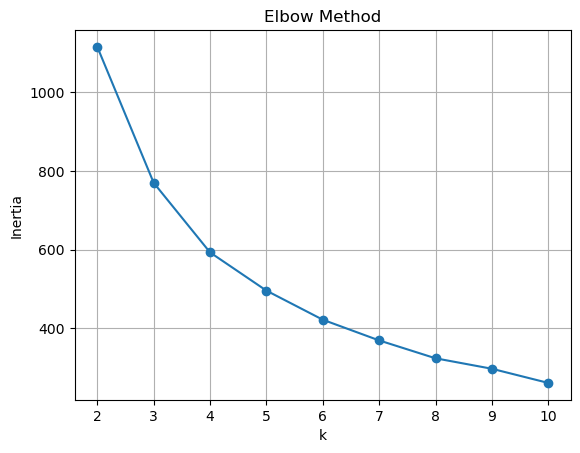

c:\Users\user\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


   symbol  cluster
0    NANO        0
1     WTC        0
2     WAN        0
3    VERI        0
4   STRAT        0
5     PPT        0
6    IOST        0
7     ICX        0
8      HC        0
9     GNT        0
10    ZRX        0
11   ARDR        0
12    ARK        0
13    BAT        0
14    BCD        0
15    XRP        1
16    XLM        1
17    EOS        2
18    XTZ        2
19    XMR        2
20     AE        2
21  WAVES        2
22    VET        2
23    TRX        2
24  STEEM        2
25    SNT        2
26   DASH        2
27   QTUM        2
28    OMG        2
29    ETC        2
30    ETH        2
31    BTC        2
32    BNB        2
33    ONT        2
34    KMD        2
35    LSK        2
36    KCS        2
37    LTC        2
38  MIOTA        2
39    ZIL        2
40    NEO        2
41    ADA        2
42   USDT        3
43    BCH        4
44    MKR        4
45    BTG        4
46   RHOC        4
47    ZEC        4
48    XEM        5


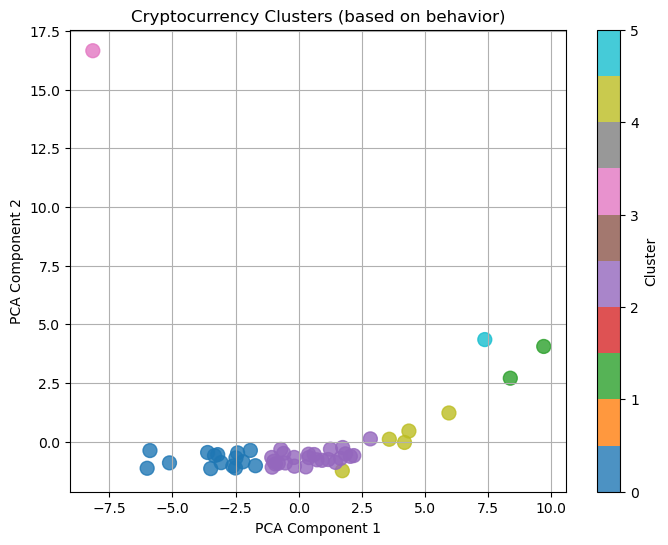

In [5]:
# Preprocess
df['date'] = pd.to_datetime(df['date'])
df.sort_values(['symbol', 'date'], inplace=True)

# Step 1: Filter to Top 50 Coins by Average Market Cap
top_symbols = df.groupby('symbol')['market'].mean().sort_values(ascending=False).head(50).index
df = df[df['symbol'].isin(top_symbols)]

# Step 2: Aggregate duplicates by (date, symbol) using mean close price
df_agg = df.groupby(['date', 'symbol'])['close'].mean().reset_index()

# Step 3: Create pivot table (rows: dates, columns: symbols, values: close prices)
pivot = df_agg.pivot(index='date', columns='symbol', values='close')

# Step 4: Select a fixed window of recent days
lookback_days = 30
pivot = pivot.tail(lookback_days)

# Step 5: Drop cryptos (columns) with insufficient data in the lookback window
pivot = pivot.dropna(axis=1, thresh=lookback_days)

# Optional: fill small gaps if you want to preserve more coins
pivot = pivot.fillna(method='ffill').fillna(method='bfill')

# Step 6: Normalize each crypto's close price (z-score)
normalized = pivot.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# Step 7: Transpose so each row is a crypto
X = normalized.T.dropna()

# Step 8: Scale features (not mandatory after z-score, but good practice)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 9: Elbow method to choose number of clusters
inertia = []
K_range = range(2, min(11, len(X_scaled)))  # Avoid k > n_samples
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

# Step 10: Final clustering with chosen k (e.g., k=4)
k = 6
if len(X_scaled) >= k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    # Add cluster labels to DataFrame
    clustered_df = pd.DataFrame({'symbol': X.index, 'cluster': clusters})
    print(clustered_df.sort_values('cluster').reset_index(drop=True))

    # Step 11: Visualize using PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap='tab10', s=100, alpha=0.8)
    plt.title('Cryptocurrency Clusters (based on behavior)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True)
    plt.show()
else:
    print(f"Not enough cryptos with complete data to form {k} clusters.")

c:\Users\LENOVO\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


   symbol  cluster
0     KCS        0
1     XTZ        0
2    USDT        1
3    RHOC        2
4     BCH        2
5     BTG        2
6     ZEC        2
7   WAVES        3
8     VET        3
9    VERI        3
10    LSK        3
11    WTC        3
12  STRAT        3
13  STEEM        3
14    SNT        3
15    PPT        3
16    ZIL        3
17    WAN        3
18   NANO        3
19    ZRX        3
20   IOST        3
21     AE        3
22   ARDR        3
23    ICX        3
24     HC        3
25    ARK        3
26    GNT        3
27    BAT        3
28    BCD        3
29    KMD        3
30    XRP        4
31    XLM        4
32    XEM        4
33    XMR        5
34    BNB        5
35    BTC        5
36    TRX        5
37    EOS        5
38    ETC        5
39    ETH        5
40   QTUM        5
41    ONT        5
42    OMG        5
43    NEO        5
44    MKR        5
45  MIOTA        5
46    LTC        5
47   DASH        5
48    ADA        5


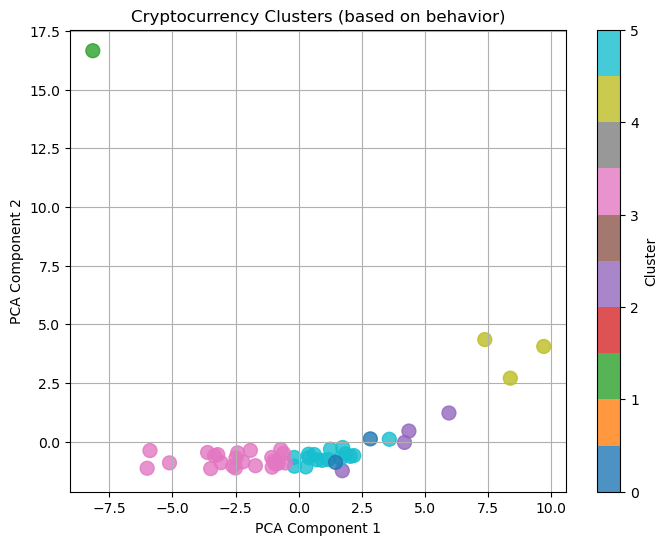

In [19]:

# Step 10: Final clustering with chosen k (e.g., k=4)
k = 6
if len(X_scaled) >= k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    # Add cluster labels to DataFrame
    clustered_df = pd.DataFrame({'symbol': X.index, 'cluster': clusters})
    print(clustered_df.sort_values('cluster').reset_index(drop=True))

    # Step 11: Visualize using PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap='tab10', s=100, alpha=0.8)
    plt.title('Cryptocurrency Clusters (based on behavior)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True)
    plt.show()
else:
    print(f"Not enough cryptos with complete data to form {k} clusters.")

In [20]:
# Print coins grouped by cluster
for cluster_id in sorted(clustered_df['cluster'].unique()):
    group = clustered_df[clustered_df['cluster'] == cluster_id]
    symbols = group['symbol'].tolist()
    print(f"\n🟢 Cluster {cluster_id} ({len(symbols)} coins):")
    print(", ".join(symbols))


🟢 Cluster 0 (2 coins):
KCS, XTZ

🟢 Cluster 1 (1 coins):
USDT

🟢 Cluster 2 (4 coins):
BCH, BTG, RHOC, ZEC

🟢 Cluster 3 (23 coins):
AE, ARDR, ARK, BAT, BCD, GNT, HC, ICX, IOST, KMD, LSK, NANO, PPT, SNT, STEEM, STRAT, VERI, VET, WAN, WAVES, WTC, ZIL, ZRX

🟢 Cluster 4 (3 coins):
XEM, XLM, XRP

🟢 Cluster 5 (16 coins):
ADA, BNB, BTC, DASH, EOS, ETC, ETH, LTC, MIOTA, MKR, NEO, OMG, ONT, QTUM, TRX, XMR



🟢 DBSCAN Cluster -1 (49 coins):
ADA, AE, ARDR, ARK, BAT, BCD, BCH, BNB, BTC, BTG, DASH, EOS, ETC, ETH, GNT, HC, ICX, IOST, KCS, KMD, LSK, LTC, MIOTA, MKR, NANO, NEO, OMG, ONT, PPT, QTUM, RHOC, SNT, STEEM, STRAT, TRX, USDT, VERI, VET, WAN, WAVES, WTC, XEM, XLM, XMR, XRP, XTZ, ZEC, ZIL, ZRX


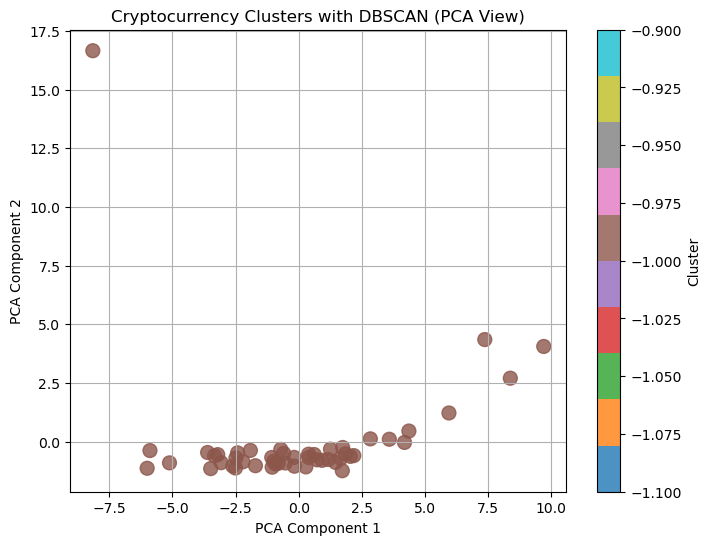

In [6]:
from sklearn.cluster import DBSCAN

# Step 1: Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=2)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Step 2: Create DataFrame with DBSCAN cluster results
dbscan_df = pd.DataFrame({'symbol': X.index, 'cluster': dbscan_labels})

# Step 3: Display cluster members
for cluster_id in sorted(dbscan_df['cluster'].unique()):
    symbols = dbscan_df[dbscan_df['cluster'] == cluster_id]['symbol'].tolist()
    print(f"\n🟢 DBSCAN Cluster {cluster_id} ({len(symbols)} coins):")
    print(", ".join(symbols))

# Step 4 (optional): Visualize with PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(components[:, 0], components[:, 1], c=dbscan_labels, cmap='tab10', s=100, alpha=0.8)
plt.title("Cryptocurrency Clusters with DBSCAN (PCA View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()



Cluster 0 (3 coins):
XEM, XLM, XRP

Cluster 1 (20 coins):
ADA, BCH, BNB, BTC, BTG, DASH, EOS, ETC, ETH, KCS, MIOTA, MKR, NEO, OMG, ONT, QTUM, RHOC, XMR, XTZ, ZEC

Cluster 2 (25 coins):
AE, ARDR, ARK, BAT, BCD, GNT, HC, ICX, IOST, KMD, LSK, LTC, NANO, PPT, SNT, STEEM, STRAT, TRX, VERI, VET, WAN, WAVES, WTC, ZIL, ZRX

Cluster 3 (1 coins):
USDT


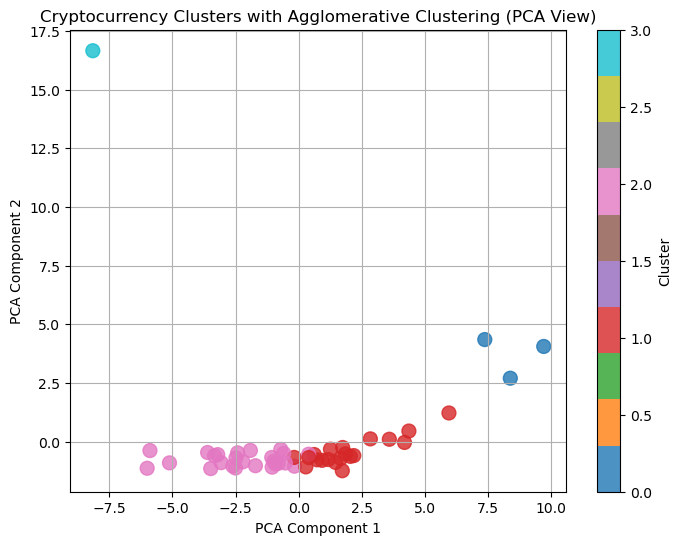

In [7]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo.fit_predict(X_scaled)

# Step 2: Attach cluster labels to DataFrame
agglo_df = pd.DataFrame({'symbol': X.index, 'cluster': agglo_labels})

# Step 3: Display coins per cluster
for cluster_id in sorted(agglo_df['cluster'].unique()):
    symbols = agglo_df[agglo_df['cluster'] == cluster_id]['symbol'].tolist()
    print(f"\nCluster {cluster_id} ({len(symbols)} coins):")
    print(", ".join(symbols))

# Step 4 (Optional): PCA visualization
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(components[:, 0], components[:, 1], c=agglo_labels, cmap='tab10', s=100, alpha=0.8)
plt.title("Cryptocurrency Clusters with Agglomerative Clustering (PCA View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


In [24]:
import plotly.express as px
import numpy as np

# Assign dummy x and y positions within each cluster
clustered_df['x'] = 0
clustered_df['y'] = 0

# Offset positions by cluster (to keep them visually grouped)
offset = 5
for cid in clustered_df['cluster'].unique():
    idx = clustered_df['cluster'] == cid
    n = idx.sum()
    angle = np.linspace(0, 2 * np.pi, n, endpoint=False)
    clustered_df.loc[idx, 'x'] = np.cos(angle) + cid * offset
    clustered_df.loc[idx, 'y'] = np.sin(angle)

# Fixed bubble size
clustered_df['bubble_size'] = 10

# Interactive plot
fig = px.scatter(
    clustered_df,
    x='x',
    y='y',
    color='cluster',
    hover_name='symbol',
    size='bubble_size',
    size_max=8,
    title='Cryptocurrency Clusters (Grouped by Behavior)',
)

fig.update_traces(marker=dict(sizemode='diameter'), selector=dict(mode='markers'))
fig.update_layout(
    showlegend=True,
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
    template='plotly_dark',
    title_x=0.5,
)

fig.show()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9364\3794985004.py:14: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[26.         25.92387953 25.70710678 25.38268343 25.         24.61731657
 24.29289322 24.07612047 24.         24.07612047 24.29289322 24.61731657
 25.         25.38268343 25.70710678 25.92387953]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9364\3794985004.py:15: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.00000000e+00  3.82683432e-01  7.07106781e-01  9.23879533e-01
  1.00000000e+00  9.23879533e-01  7.07106781e-01  3.82683432e-01
  1.22464680e-16 -3.82683432e-01 -7.07106781e-01 -9.23879533e-01
 -1.00000000e+00 -9.23879533e-01 -7.07106781e-01 -3.82683432e-01]' has dtype incompatible with int64, please explicitly cast